<a href="https://colab.research.google.com/github/pranjalrawat007/Ames-Housing-Prices/blob/master/Ames_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

* One of the most fascinating datasets that I've come across is the Ames Housing dataset. It was originally collated by Dr. Dean De Cock (Truman State Univ) for the undergraduate statistical methods course, and later became very popular through Kaggle.
* It contains rich information captured at the point of sale of houses in Ames (Iowa, US) from 2006 to 2010. Among others we have the location and various area measurements of the house, the immediate context of sale, the condition of rooms, etc..
* One of the popular "tasks" on this dataset to try and predict the Sale Price from the attributes of the house - its location, size, quality, etc. But there can be other interesting "tasks".
* While Kaggle split the data into train and test sets, the original dataset is larger and more complete.


In [90]:
PATH = '/content/drive/My Drive/Projects/Machine Learning/Real World Problems/Housing Prices/AmesHousing.xls'
import pandas as pd
df = pd.read_excel(PATH)
df.columns = [i.replace(' ', '') for i in df.columns]
df[['PID', 'SalePrice', 'Neighborhood', 'GrLivArea', 'YrSold', 'MoSold']].sample(frac = 1).head(10)

,PID,SalePrice,Neighborhood,GrLivArea,YrSold,MoSold
1646,527302060,176000,NWAmes,1479,2007,3
2912,923226150,146500,Mitchel,1652,2006,3
2752,906380170,194000,CollgCr,1220,2006,7
2799,907285100,237000,CollgCr,1995,2006,7
1517,909175050,179500,SWISU,2192,2008,7
1559,911370410,392500,Crawfor,1652,2008,11
1712,528172050,245700,NridgHt,1614,2007,5
222,905105200,137900,Sawyer,892,2010,6
619,534476320,128900,NAmes,1050,2009,6
966,916460110,170000,Timber,2014,2009,2


# **The Target: Sale Price in $**

Two observations: 
1. A majority of houses are sold for less, a minority of houses are sold for a really, really high amount. Sale Price exhibits high left skew, and thus needs to be log-transformed. 
2. Post log-transformation, we detect outliers by plotting MEAN -+2 STD vertical bars. 

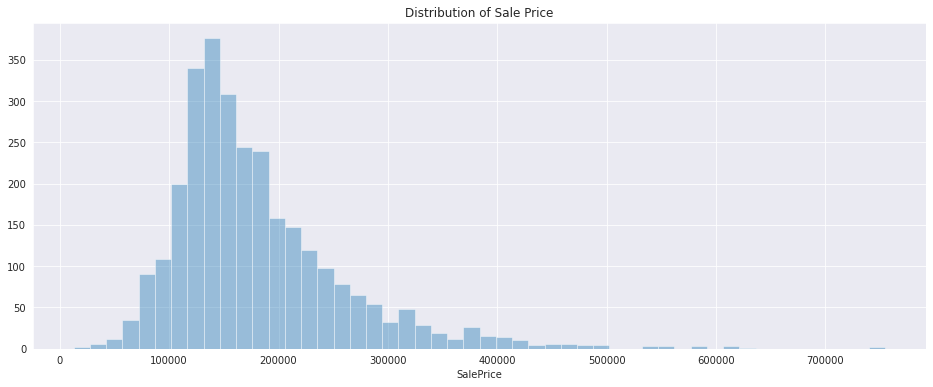

In [91]:
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)

sns.distplot(df.SalePrice, hist=True, kde = False)
plt.title('Distribution of Sale Price')
plt.show()

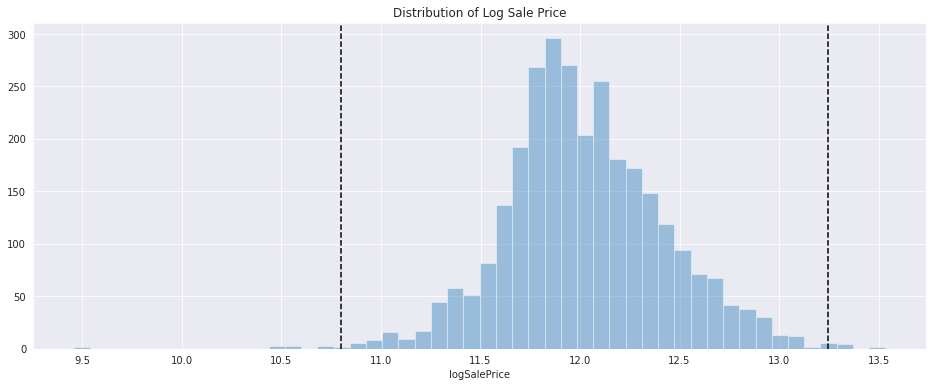

In [92]:
df['logSalePrice'] = np.log(df.SalePrice)
sns.distplot(df.logSalePrice, hist=True, kde = False)
plt.title('Distribution of Log Sale Price')

# Outlier Thresholds
μ = df.logSalePrice.mean()
σ = df.logSalePrice.std()
plt.axvline(μ - 3 * σ, color='black', linestyle = '--')
plt.axvline(μ + 3 * σ, color='black', linestyle = '--')

plt.show()

* We remove outliers below and above these statistical thresholds. 
* Additionally, by the recommendation of the author we remove houses with "GrLivArea" greater than 4000. 

In [93]:
old_examples = df.shape[0]
df = df[(df.logSalePrice > μ - 3 * σ) &
        (df.logSalePrice < μ + 3 * σ) & 
        (df.GrLivArea<4000)]
new_examples = df.shape[0]
print(old_examples, new_examples)

2930 2907


* A total of 23 records are dropped, and we are left with 2907 records. 

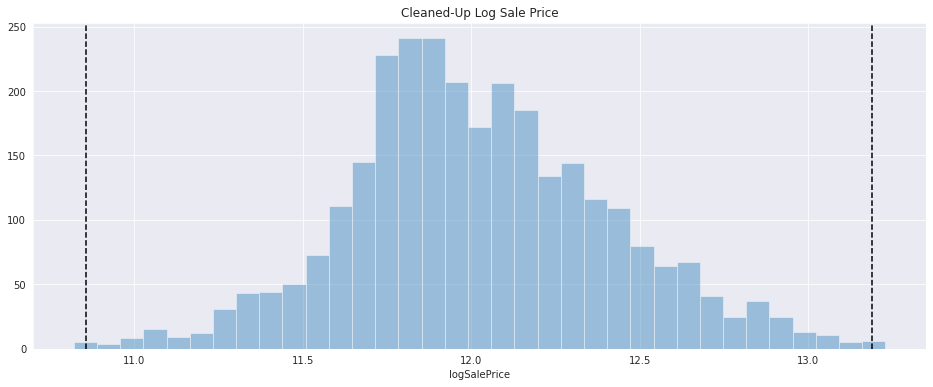

In [94]:
sns.distplot(df.logSalePrice, hist=True, kde = False)
plt.title('Cleaned-Up Log Sale Price')
μ = df.logSalePrice.mean()
σ = df.logSalePrice.std()
plt.axvline(μ - 3 * σ, color='black', linestyle = '--')
plt.axvline(μ + 3 * σ, color='black', linestyle = '--')
plt.show()

# **Variation of Price by Location**
* SalePrices vary a lot by Neighbourhood & Section (from PIN)


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_categorical(var):
    plt.figure(figsize=(16, 6))
    my_order = df[['SalePrice', var]].groupby(by=var).mean().sort_values('SalePrice').index
    chart = sns.violinplot(x=var, y='SalePrice', data=df, order=my_order)
    chart.axhline(y = df.SalePrice.mean(), color='black', linewidth=2) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
    return chart

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
def regression_model(var, return_weights = False):
    x, y = pd.get_dummies(df[var]), df.SalePrice
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 42)
    
    model = MLPRegressor(hidden_layer_sizes=(20,), alpha = 2, learning_rate_init=0.01, max_iter=1000, random_state = 42)
    model.fit(x_train, y_train)
    if return_weights == True:
        return model.coefs_
    print(r2_score(y_train, model.predict(x_train)), r2_score(y_val, model.predict(x_val)))

    plt.figure(figsize=(16, 6))
    plt.plot(y_train, y_train)
    plt.scatter(y_train, model.predict(x_train))
    plt.show()


In [0]:
plot_categorical('MSZoning')
regression_model('MSZoning')

In [0]:
df['Zone'] = df.MSZoning.astype(str) + '~' + df.MSSubClass.astype(str)
plot_categorical('Zone')
regression_model('Zone')

In [0]:
plot_categorical('Neighborhood')
regression_model('Neighborhood')

In [0]:
df.PID = df.PID.astype(str) # Postal Identification Number
df['PID1']=df.PID.str[0:1] # township
df['PID2']=df.PID.str[1:3] # section number
df['PID3']=df.PID.str[3:6] # quarter section (N, E, S, W, etc)
df['PID4']=df.PID.str[6:10] # parcel number within section

In [0]:
plot_categorical('PID2')
regression_model('PID2')

In [0]:
plot_categorical('PID3')
regression_model('PID3')

In [0]:
plot_categorical('PID4')
regression_model('PID4')

In [0]:
plot_categorical('Condition1')
regression_model('Condition1')

In [0]:
plot_categorical('Condition2')
regression_model('Condition2')

In [0]:
keyLocationAttributes = ['Neighborhood', 'PID2', 'Zone']
coef = regression_model(keyLocationAttributes, return_weights=True)

In [0]:
for i in coef:
    print(i.shape)

(106, 100)
(100, 1)


In [0]:
eM = coef[0]
eM.shape

(106, 100)

# Context of Sale
* Does not seem to have any significant effect. 

0.08989407979589081 0.14527501146496014


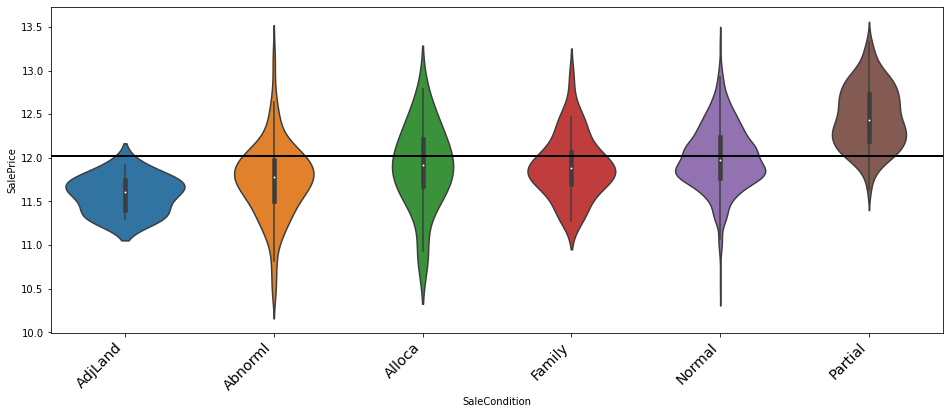

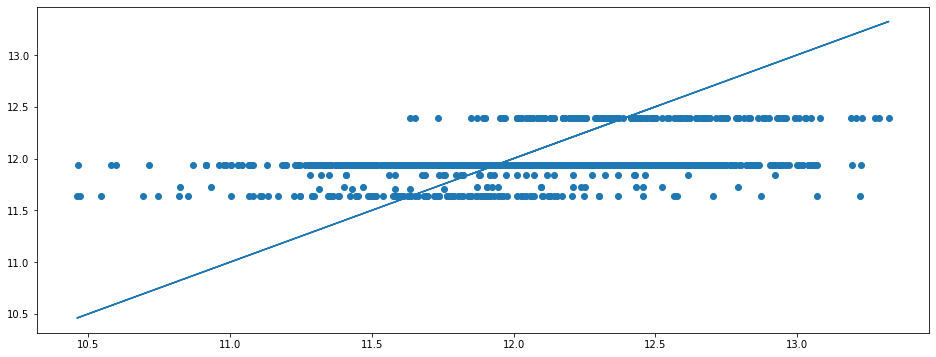

In [0]:
plot_categorical('SaleCondition')
regression_model('SaleCondition')

0.10674419934127866 0.13913094584412988


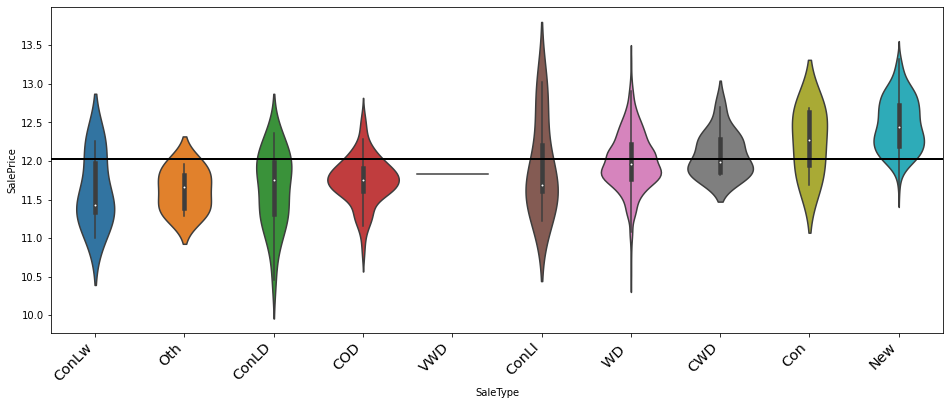

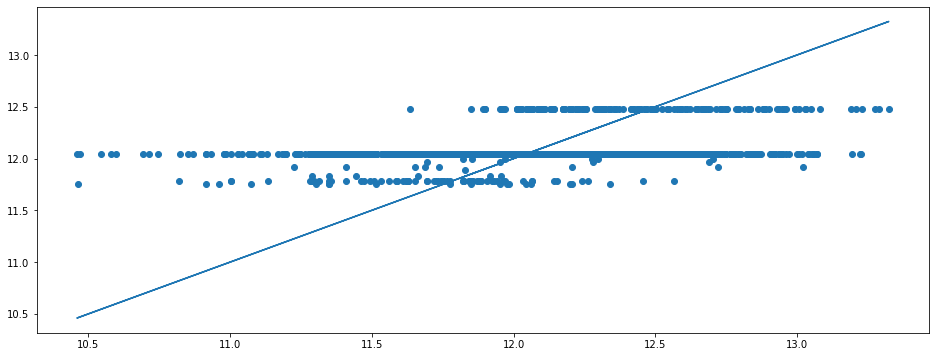

In [0]:
plot_categorical('SaleType')
regression_model('SaleType')

0.0009556132307242393 -0.014616219508186035


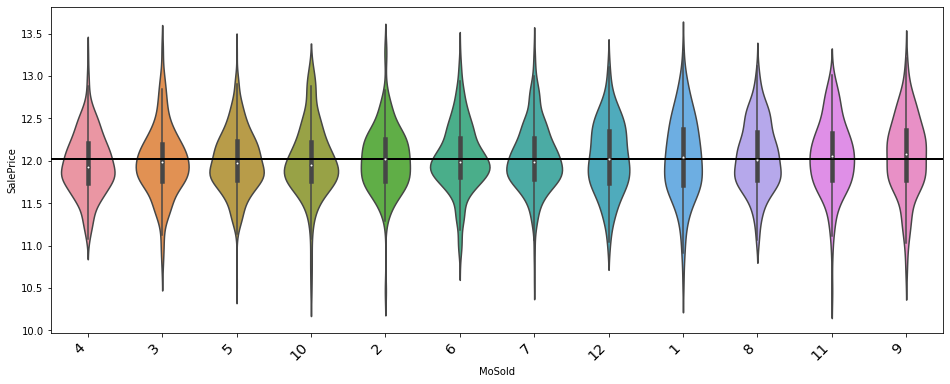

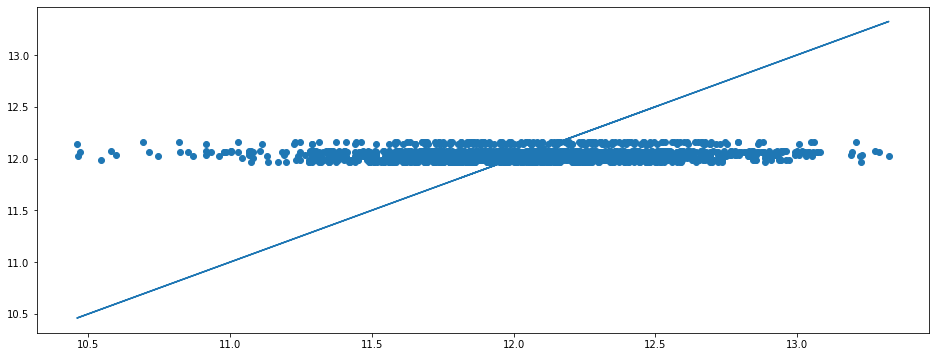

In [0]:
plot_categorical('MoSold')
regression_model('MoSold')

-0.019410817390614676 -0.044146156948597026


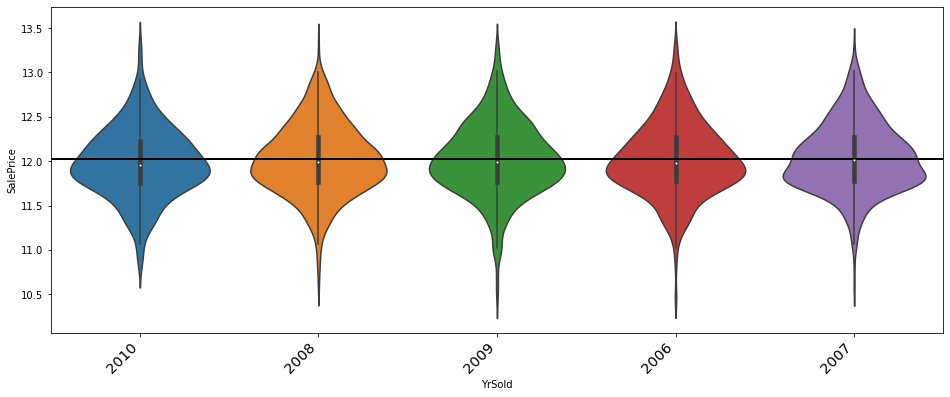

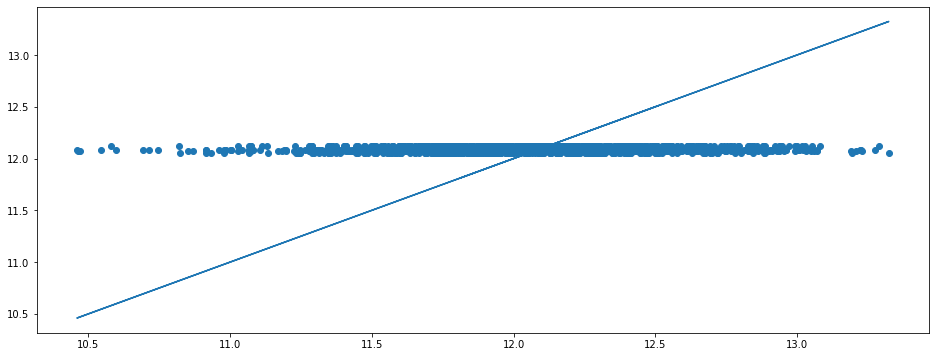

In [0]:
plot_categorical('YrSold')
regression_model('YrSold')

0.006909498505049849 -0.059339581739229486


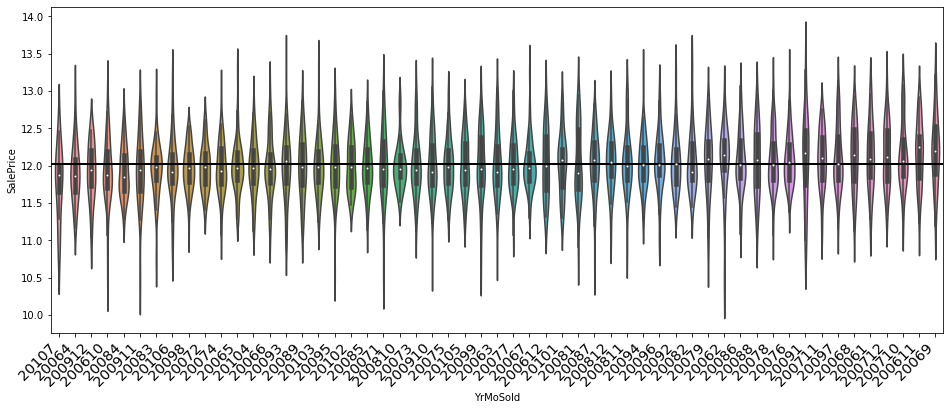

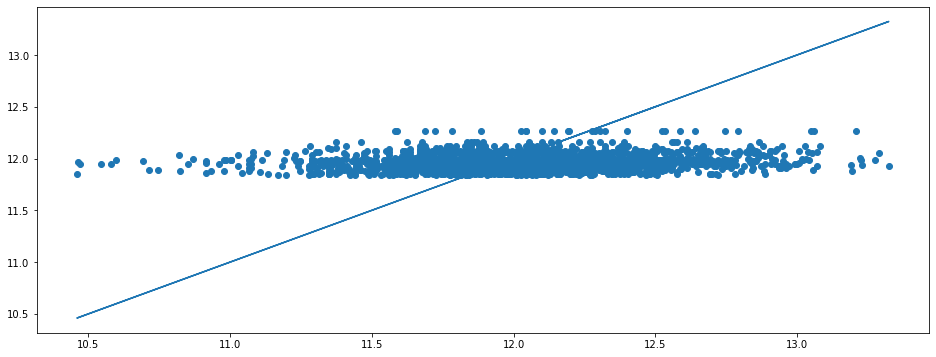

In [0]:
df['YrMoSold'] = df.YrSold.astype(str) + df.MoSold.astype(str)
plot_categorical('YrMoSold')
regression_model('YrMoSold')

In [0]:
keyLocationAttributes = ['SaleType', 'SaleCondition']
coef = regression_model(keyLocationAttributes, return_weights=True)

# House Size & Area
* Key takeaways - The Right Definition of Floor Area should be applied. Price is dependent on the right area. 

In [0]:
df.select_dtypes(include = ['float', 'int']).head().columns

Index(['Order', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [0]:
df['PorchArea'] = df.OpenPorchSF +df.EnclosedPorch +df['3SsnPorch'] + df.ScreenPorch
df['FloorArea1'] = df.TotalBsmtSF + df['1stFlrSF'] + df['2ndFlrSF']
df['FloorArea2'] = df.TotalBsmtSF + df['1stFlrSF'] + df['2ndFlrSF'] + df.EnclosedPorch + df.ScreenPorch + df['3SsnPorch']
df['FloorArea3'] = df.BsmtFinSF1 + 2 * df['1stFlrSF'] + df['2ndFlrSF'] + df.WoodDeckSF + df.PorchArea + 2* df.GarageArea 
df['OutdoorArea']  = df.LotArea - df['1stFlrSF']
df['FloorAreaRatio'] = df['FloorArea3']/df['PorchArea']
#areaFeatures = ['LotArea', 'OutdoorArea', 'FloorArea1','FloorArea2','FloorArea3', 'GrLivArea', 'GarageArea']
areaFeatures = ['LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'FloorArea3', 'FloorArea2', 'FloorArea1', 'PorchArea', 'OutdoorArea', 'FloorAreaRatio'
       ]
df[areaFeatures] = df[areaFeatures].fillna(0)
df[areaFeatures].head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,FloorArea3,FloorArea2,FloorArea1,PorchArea,OutdoorArea,FloorAreaRatio
726,7879,0.0,495.0,0.0,225.0,720.0,720,0,0,720,0.0,0,523,115,0,0,0,2573.0,1555.0,1440.0,638,7159,4.032915
2843,8088,0.0,0.0,0.0,498.0,498.0,498,0,0,498,216.0,0,0,100,0,0,0,1528.0,1096.0,996.0,100,7590,15.280000
2880,9000,0.0,50.0,0.0,430.0,480.0,480,0,0,480,308.0,0,0,0,0,0,0,1626.0,960.0,960.0,0,8520,inf
709,5925,0.0,0.0,0.0,600.0,600.0,600,368,0,968,0.0,0,0,0,0,0,0,1568.0,1568.0,1568.0,0,5325,inf
1901,5000,0.0,0.0,0.0,0.0,0.0,334,0,0,334,0.0,0,0,0,0,0,0,668.0,334.0,334.0,0,4666,inf


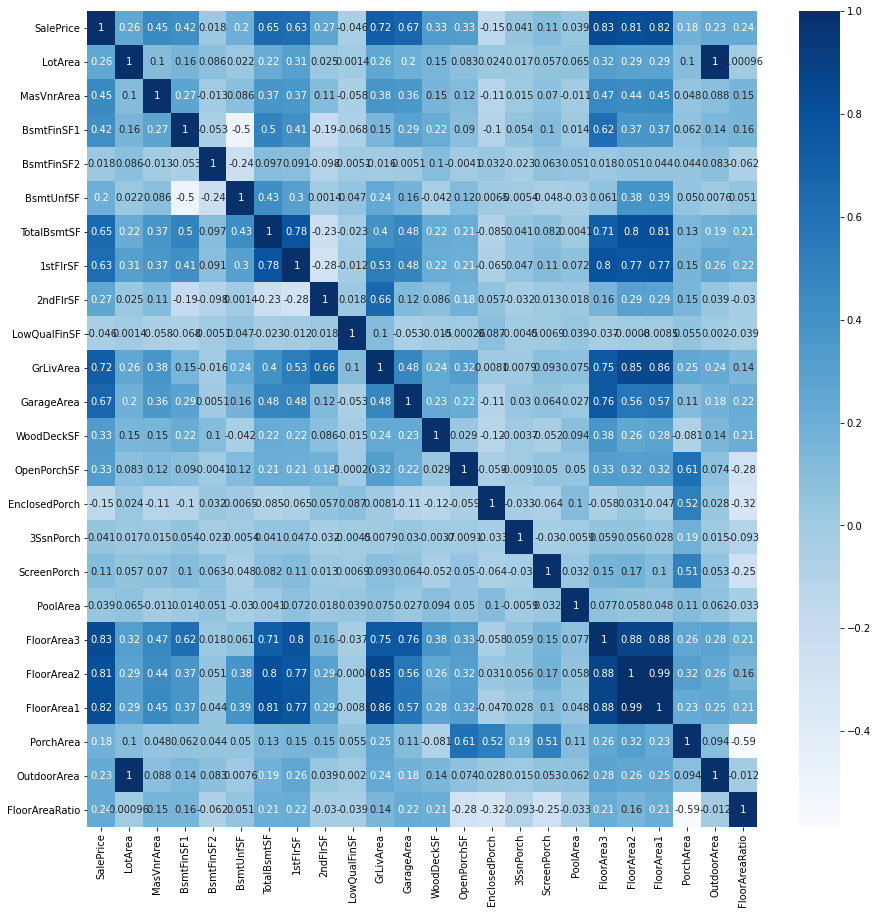

In [0]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[['SalePrice']+ areaFeatures].corr(), annot=True, cmap = 'Blues')

In [0]:
areaFeatures = ['TotalBsmtSF', 'GrLivArea', 'GarageArea','FloorArea1']

In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
def regression_model2(var, return_weights = False):
    model = MLPRegressor(hidden_layer_sizes=(100, ), alpha = 3, learning_rate_init=0.01, max_iter=20000, random_state = 42)
    y = df.SalePrice
    df[var] = (df[var]-df[var].mean(axis = 0))/(df[var].std(axis = 0))
    x, y = df[var], df.SalePrice
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 42)
    model.fit(x_train, y_train)
    print(r2_score(y_train, model.predict(x_train)), r2_score(y_val, model.predict(x_val)))
    if return_weights == True:
        return model.coefs_
        
    plt.figure(figsize=(16, 6))
    plt.plot(y_train, y_train)
    plt.scatter(y_train, model.predict(x_train))
    plt.show()

    for i in var:
        plt.scatter(x_train[i], model.predict(x_train))
        plt.title(i)
        plt.show()


0.7269140738653929 0.7390095585649867


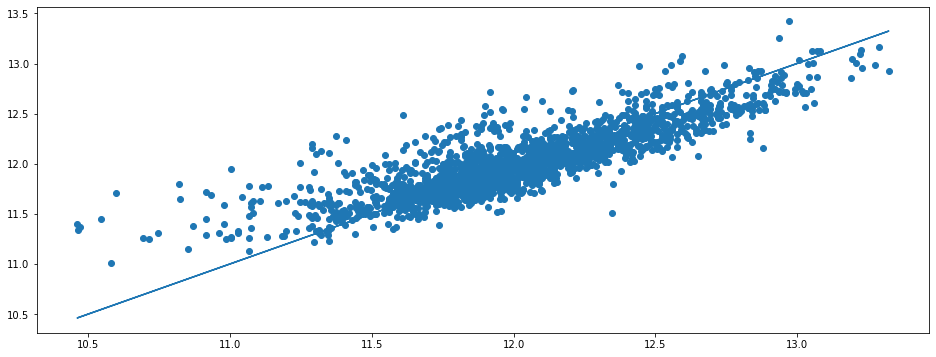

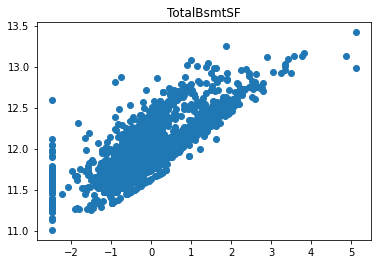

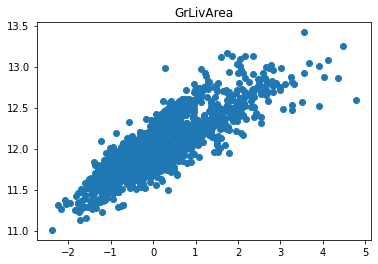

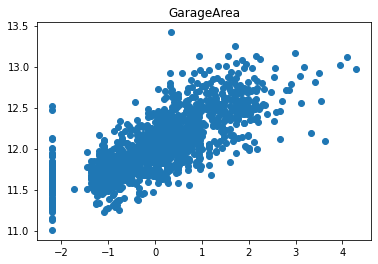

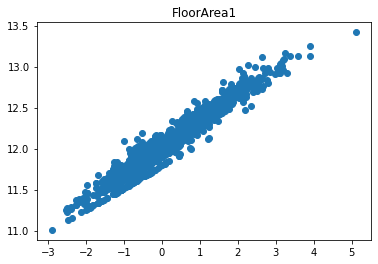

In [0]:
areaFeatures = ['TotalBsmtSF', 'GrLivArea', 'GarageArea','FloorArea1']
regression_model2(areaFeatures)

In [0]:
f = list(df.columns)
f.drop('Order', 'PID')

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

In [0]:
var = areaFeatures
model = MLPRegressor(hidden_layer_sizes=(100, ), alpha = 3, learning_rate_init=0.01, max_iter=10000, random_state = 42)
y = df.SalePrice
df[var] = (df[var]-df[var].mean(axis = 0))/(df[var].std(axis = 0))
x, y = df[var], df.SalePrice
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 42)
model.fit(x_train, y_train)
print(r2_score(y_train, model.predict(x_train)), r2_score(y_val, model.predict(x_val)))

0.6911405032509836 0.6901373049147072


In [0]:
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_val)

In [0]:
yhat = model.predict(x[areaFeatures])

In [0]:
var = ['Neighborhood', 'PID2', 'Zone']
x2 = pd.DataFrame([[]])
for i in var:
    x2 = pd.concat([x2, pd.get_dummies(df[i])], axis = 1)
y2 = yhat
x2.shape, y2.shape


((2918, 106), (2918,))

In [0]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(x2, y2, test_size = 0.3, random_state = 42)
model2 = MLPRegressor(hidden_layer_sizes=(100, ), alpha = 3, learning_rate_init=0.01, max_iter=10000, random_state = 42)
model2.fit(x_train2, y_train2)
print(r2_score(y_train2, model2.predict(x_train2)), r2_score(y_val2, model2.predict(x_val2)))

0.04855021237855084 -0.035088942405500756


# Interior Components